In [2]:
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
import pandas ,numpy,re,math
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.metrics.pairwise import pairwise_distances    #获取距离
from scipy.stats import pearsonr
from collections import Counter

# data_process

In [5]:
path=r'.\input\bbcsport\bbcsport_nmf.xlsx'

data_initial=pd.read_excel(path)


vocab_max_size=10000   
vocab_min_count=5
data=data_initial['new_nltk'].values.tolist()
data_matrix=[text.split()  for text in data]
data=[ele for row in data_matrix for ele in row]

vocab =Counter(data)
vocab_arr = [[wd, vocab[wd]] for wd in vocab if vocab[wd] >vocab_min_count] 
vocab_arr = sorted(vocab_arr, key=lambda k: k[1])[::-1]   
vocab_arr = sorted(vocab_arr)              
vocab2id = {value[0]:itm for itm,value in enumerate(vocab_arr)}

#text-word
doc_word_matrix=[]
for row in data_matrix:
    temp_row=[]
    for word in row:
        if word in vocab2id:
            temp_row.append(vocab2id[word])
    doc_word_matrix.append(temp_row)

#text-word
doc_word_matrix1=[]
for row in data_matrix:
    temp_row=[]
    for word in row:
        if word in vocab2id:
            temp_row.append(word)
    doc_word_matrix1.append(temp_row)  
    
    
from sklearn.feature_extraction.text import CountVectorizer
docs = doc_word_matrix  
vocab = list(vocab2id.keys())  
n_docs = len(docs)   
n_terms = len(vocab) 
fix_seed=np.random.seed(0)
print(f'the number of docs{n_docs},the number of word{n_terms}')


dt_mat = np.zeros([n_docs,n_terms])
for k in range(n_docs):
    for j in docs[k]:
        dt_mat[k, j] = dt_mat[k, j]+1.0
        # if k==0:
        #     print(k,'  ',j,dt_mat[k, j])
print('term doc matrix done')


#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
doc_word_matrix_temp=['  '.join(doc) for doc in doc_word_matrix1]
tv = TfidfVectorizer()  
tv_fit = tv.fit_transform(doc_word_matrix_temp)
tfidf_matrix=pd.DataFrame(tv_fit.toarray(),columns=tv.get_feature_names_out())
print('tf-idf',tv_fit.toarray().shape)

#insert tag
data_initial.insert(3, 'tag',list(range(n_docs)))

the number of docs737,the number of word3272
term doc matrix done
tf-idf (737, 3272)


In [9]:
dt_mat = np.zeros([n_docs,n_terms])
for k in range(n_docs):
    for j in docs[k]:
        dt_mat[k, j] = dt_mat[k, j]+1.0
        # if k==0:
        #     print(k,'  ',j,dt_mat[k, j])

print('term doc matrix done')

term doc matrix done


# NMF,ARI,ACC（Compare models）

In [47]:

def add_to_excel(labels,pred):
    class_=labels
    class_count=Counter(labels)
    start_index,end_index=0,0
    true=np.zeros(len(class_))
    for num in (class_count.values()):
        end_index+=num
        temp_count=Counter(pred[start_index:end_index])
        max_key=0
#         print('-----------')
        for k, v in temp_count.items():
            if v == max(list(temp_count.values())):
                max_key = k   
#         print(max_key,temp_count)
        true[start_index:end_index]=max_key
#         print(f'{start_index}--{end_index}')
        start_index+=num
    return true,pred


#NMI
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples

def evaluate(A,B):
    print(f' NMI :  ',round(metrics.normalized_mutual_info_score(A,B),3))   # 直接调用sklearn中的函数
    print(f' ARI :  ',round(metrics.adjusted_rand_score(A, B),3))
    acc=0
    for i in range(len(A)):
        if A[i]!=B[i]:
            acc+=1
    acc=(len(A)-acc)/len(A)
    print(f' ACC :  ',acc)
    return round(metrics.normalized_mutual_info_score(A,B),3),round(metrics.adjusted_rand_score(A, B),3),acc
    
path=r'D:\python\python代码\数据分析\杂七杂八学习\第一篇论文方法\input\bbcsport\bbcsport_nmf_nndsvd.xlsx'

data_initial=pd.read_excel(path)
labels,pred=data_initial['type'].tolist(),data_initial['topic5'].tolist()
true,pred_=add_to_excel(labels,pred)
nmi,ari,acc=evaluate(true,pred_)


 NMI :   0.836
 ARI :   0.856
 ACC :   0.9199457259158752


In [ ]:
 0.8778304370721433

# The proposed method (AICDR)

In [9]:
#Classify data installation labels
def classify_cluster(topic,matrix):
    global data_initial
    data_temp=data_initial[['tag',topic]]
    topics=list(set(data_temp[topic].values.tolist()))
    matrix_3=[]
    for topic_ in topics:
        tags=data_temp[data_temp[topic]==topic_]['tag'].values.tolist()
        tags = np.array(tags).astype(int).tolist()
        matrix_3.append(matrix[tags,])
    return matrix_3
#Calculate the diameter of each class, which is a two-dimensional matrix
def calculate_diameter(matrix_2):
    #Calculate the mean (center vector) of a class
    cluster_n=len(matrix_2)
    cluster_t=np.array(matrix_2[0])
    for i in range(1,cluster_n):
        vector_i=np.array(matrix_2[i])
        cluster_t=vector_i+cluster_t
    cluster_u=cluster_t/cluster_n
    #calculate diameter
    cluster_diameter=0
    cluster_u=np.array(cluster_u)
    for j in matrix_2:
        cluster_j=np.array(j)
        vec=cluster_u-cluster_j
        cluster_diameter=np.linalg.norm(vec)+cluster_diameter
    return cluster_diameter
#Calculate the diameter of two major classes
def calculate_diameter_2(matrix_3):
    matrix_3_n=len(matrix_3)
    cluster_diameter_dict2={}
    for i in range(matrix_3_n):
        cluster_i=matrix_3[i] 
        cluster_i_n=len(cluster_i) 
        for j in range(i+1,matrix_3_n):
            cluster_j=matrix_3[j] 
            cluster_j_n=len(cluster_j)  
            cluster_n=cluster_i_n+cluster_j_n 
            cluster_i_j=np.concatenate((cluster_i,cluster_j))
                    
            #Calculate the mean (center vector) of major classes
            cluster_t=np.array(cluster_i_j[0])  
            for m in range(1,cluster_n):
                vector_m=np.array(cluster_i_j[m])
                cluster_t=vector_m+cluster_t
            cluster_u=cluster_t/cluster_n
            
            #Calculate the diameter of major categories
            cluster_diameter=0
            cluster_u=np.array(cluster_u)
            for k in cluster_i_j:
                cluster_k=np.array(k)
                vec=cluster_u-cluster_k
                cluster_diameter=np.linalg.norm(vec)+cluster_diameter
            cluster_diameter_dict2[f'{i}-{j}']=cluster_diameter
    return cluster_diameter_dict2


    
num_topic=3
matrix_3=classify_cluster(f'topic{num_topic}',tv_fit.toarray())

# After classification, the diameters of each category
matrix_3_diameter=[]
for matrix_2 in matrix_3:
    cluter_diameter=calculate_diameter(matrix_2)
#     print(cluter_diameter)
    matrix_3_diameter.append(cluter_diameter)
print('the diameters of each category:\n',matrix_3_diameter)
# ave_diameter.append(np.mean(matrix_3_diameter))

# Calculate the sum of the diameters of two classes
cluster_diameter_dict1={}
for i in range(num_topic):
    cluster_i_diameter=matrix_3_diameter[i]
    for j in range(i+1,num_topic):
        cluster_j_diameter=matrix_3_diameter[j]
#         print(f'{i}-{j}, {cluster_i_diameter}-{cluster_j_diameter},  {cluster_i_diameter+cluster_j_diameter} ')
        cluster_diameter_dict1[f'{i}-{j}']=cluster_i_diameter+cluster_j_diameter
print('the sum of the diameters of two classes\n:',cluster_diameter_dict1)

# inter-class distance
cluster_diameter_dict2=calculate_diameter_2(matrix_3)
print('Merge class diameter:\n',cluster_diameter_dict2)
cluster_diameter_dict3={key:c2-c1 for key,c2,c1 in zip(cluster_diameter_dict1.keys(),cluster_diameter_dict2.values(),cluster_diameter_dict1.values())}
print('inter-class distance sqr:\n',cluster_diameter_dict3)
inter_class_distance={key:math.sqrt(c3) for key,c3 in zip(cluster_diameter_dict3.keys(),cluster_diameter_dict3.values())}
print('inter-class distance:\n',inter_class_distance)

ave_inter_class_distance=np.mean(list(inter_class_distance.values()))
print('average distacne\n',ave_inter_class_distance)


the diameters of each category:
 [270.191717819084, 245.77568374260045, 198.79369793948473]
the sum of the diameters of two classes
: {'0-1': 515.9674015616845, '0-2': 468.9854157585687, '1-2': 444.5693816820852}
Merge class diameter:
 {'0-1': 520.9233474293477, '0-2': 473.94352634585437, '1-2': 449.20964497220444}
inter-class distance sqr:
 {'0-1': 4.9559458676632175, '0-2': 4.95811058728566, '1-2': 4.640263290119265}
inter-class distance:
 {'0-1': 2.2261953794901332, '0-2': 2.226681519051537, '1-2': 2.1541270366715293}
average distacne
 2.202334645071067


In [ ]:
# Save the average inter class distance under different categories


In [7]:
ave_inter_class_distance_dic={}
for j in range(2,21):
    print(f'Topic {j}')
    #Classify data installation labels
    num_topic=j
    matrix_3=classify_cluster(f'topic{num_topic}',tv_fit.toarray())     # LDA and NMF all use tv_fit.toarray()  
    
    # cos=class_cosine_similarity(matrix_3)
    # ave_cluster_cosine.append(cos)

    #Calculate the average inter class distance
    # After classification, the diameters of each category
    matrix_3_diameter=[]
    for matrix_2 in matrix_3:
        cluter_diameter=calculate_diameter(matrix_2)
        matrix_3_diameter.append(cluter_diameter)
    # print('the diameters of each category done')
    # Calculate the sum of the diameters of two classes
    cluster_diameter_dict1={}
    for i in range(num_topic):
        cluster_i_diameter=matrix_3_diameter[i]
        for j in range(i+1,num_topic):
            cluster_j_diameter=matrix_3_diameter[j]
            cluster_diameter_dict1[f'{i}-{j}']=cluster_i_diameter+cluster_j_diameter
    # print('the sum of the diameters of two classes done')
    # inter-class distance
    cluster_diameter_dict2=calculate_diameter_2(matrix_3)
    cluster_diameter_dict3={key:c2-c1 for key,c2,c1 in zip(cluster_diameter_dict1.keys(),cluster_diameter_dict2.values(),cluster_diameter_dict1.values())}
    inter_class_distance={key:math.sqrt(c3) for key,c3 in zip(cluster_diameter_dict3.keys(),cluster_diameter_dict3.values())}
    # print('inter-class distance done')
    #平均距离
    ave_inter_class_distance=np.mean(list(inter_class_distance.values()))
    print('average distacne\n',ave_inter_class_distance)
    ave_inter_class_distance_dic[num_topic]=ave_inter_class_distance

    print('-'*30)

# 2.8882130505285013


Topic 2
average distacne
 2.163239353429584
------------------------------
Topic 3
average distacne
 2.202334645071067
------------------------------
Topic 4
average distacne
 2.1872218334407827
------------------------------
Topic 5
average distacne
 2.0577491669423296
------------------------------
Topic 6
average distacne
 2.0552345812668023
------------------------------
Topic 7
average distacne
 1.9807191886523472
------------------------------
Topic 8
average distacne
 1.9079789830507343
------------------------------
Topic 9
average distacne
 1.8863513834370325
------------------------------
Topic 10
average distacne
 1.8902337012699977
------------------------------
Topic 11
average distacne
 1.7966745120468535
------------------------------
Topic 12
average distacne
 1.7271545636749162
------------------------------
Topic 13
average distacne
 1.7588765174087326
------------------------------
Topic 14
average distacne
 1.7330644546767244
------------------------------
Topic 15


KeyboardInterrupt: 

In [53]:
out_path='.\\output\\all_inter_class_distance.xlsx'
res=pd.read_excel(out_path)
res.insert(7,'reuter_nmf',list(ave_inter_class_distance_dic.values()))
res

,bbcsport_nmf,bbcsport_lda,bbcnews_lda,bbcsport_kmeans,bbcnews_nmf,bbcnews_kmeans,reuter_lda,reuter_nmf,reuter_kmeans,snippets1_seanmf,snippets1_gsdmm,snippets2_gsdmm,snippets2_seanmf,agnews_seanmf,agnews_gsdmm
0,2.163239,2.117229,2.661795,2.265336,3.020849,3.006245,3.360194,3.445415,3.573203,3.257855,3.259859,3.248407,3.405291,3.004583,2.953955
1,2.202335,1.907101,2.770372,2.185068,2.935853,3.022213,3.420839,3.465152,3.495104,3.217874,3.084079,3.351396,3.327781,3.095687,3.064936
2,2.187222,1.928443,2.749043,2.130910,2.817408,2.887560,3.058808,3.228314,3.299051,3.221171,3.178530,3.075037,3.060998,3.007369,2.985889
3,2.057749,2.010712,2.628700,2.138650,2.734233,2.846846,2.709094,3.071512,3.301153,2.812099,2.933408,2.851644,2.919209,2.860238,2.763101
4,2.055235,1.767290,2.463544,1.992495,2.511960,2.751830,2.565821,2.931370,3.151877,2.631071,3.016635,2.777517,2.801176,2.675449,2.640971
5,1.980719,1.675405,2.212710,2.008846,2.503127,2.600495,2.296332,2.804892,3.039625,2.785845,2.874337,2.729367,2.789189,2.692009,2.611853
6,1.907979,1.619487,2.105901,1.967535,2.416896,2.562870,2.347148,2.797709,2.979926,2.679003,2.881481,2.603849,2.721653,2.584179,2.521761
7,1.886351,1.665296,2.195950,1.857087,2.253509,2.492139,2.361468,2.722243,2.793215,2.667888,2.816158,2.641355,2.728870,2.503153,2.472879
8,1.890234,1.595119,2.193483,1.892633,2.259284,2.441806,2.260977,2.629045,2.752854,2.713634,2.719645,2.598741,2.571801,2.431071,2.331246
9,1.796675,1.532447,2.198508,1.786166,2.269412,2.399029,2.141869,2.566480,2.699973,2.633339,2.728887,2.458361,2.384571,2.383973,2.326987


In [54]:
pd.DataFrame(res).to_excel(out_path,index=False)

In [44]:
out_path=r'.\output\all_inter_class_distance.xlsx'
data=pd.read_excel(out_path)
columns=data.columns.tolist()
columns

['bbcsport_nmf',
 'bbcsport_lda',
 'bbcnews_lda',
 'bbcsport_kmeans',
 'bbcnews_nmf',
 'bbcnews_kmeans',
 'reuter_lda',
 'reuter_nmf',
 'reuter_kmeans',
 'snippets1_seanmf',
 'snippets1_gsdmm',
 'snippets2_gsdmm',
 'snippets2_seanmf',
 'agnews_seanmf',
 'agnews_gsdmm']

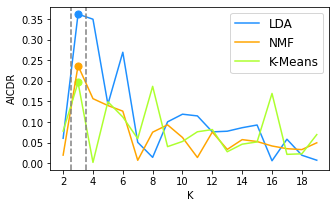

In [54]:
import matplotlib.pyplot as plt
import numpy as np
# from matplotlib import rcParams
# # rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']

x=list(range(2,21))
x1=x[:-1]
def y_new(y):
    y_new=[]
    for i in range(len(y)):
        if i<len(y)-1:
            rate=abs(y[i]-y[i+1])
            # rate=abs(y[i+1]-y[i])/y[i]
            y_new.append(rate)
    return y_new
    
y1=y_new(data['reuter_lda'].tolist())
y2=y_new(data['reuter_nmf'].tolist())
y3=y_new(data['reuter_kmeans'].tolist())

fig = plt.figure(figsize=(5,3))
plt.plot(x1,y1,color='dodgerblue')
plt.plot(x1,y2,color='orange')
plt.plot(x1,y3,color='greenyellow')

plt.legend(labels=['LDA','NMF','K-Means'], loc='upper right',prop={'size': 12})
# plt.legend(labels=['GSDMM','SeaNMF'], loc='upper right',prop={'size': 12})

plt.xlabel('K',size=10)
plt.ylabel('AICDR',size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xticks(list(range(2,22,2)))


plt.scatter(x=3,y=np.max(y1),s=50,color='dodgerblue')
plt.scatter(x=3,y=np.max(y2),s=50,color='orange')
plt.scatter(x=3,y=np.max(y3),s=50,color='greenyellow')
plt.axvline(x=2.5, color='gray', linestyle='--')  # x=0.3 表示线条位于 x 轴 0.3 的位置
plt.axvline(x=3.5, color='gray', linestyle='--')  # x=0.3 表示线条位于 x 轴 0.3 的位置

plt.savefig(r'.\output\reuter_AICDR.png',dpi=1000,bbox_inches = 'tight') 

# Elbow Method

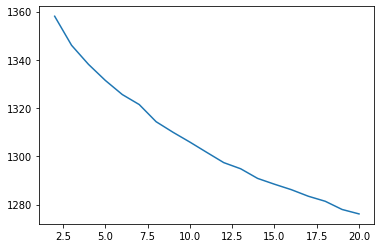

In [31]:
#Classify data installation labels
def classify_cluster(topic,matrix):
    global data_initial
    data_temp=data_initial[['tag',topic]]
    topics=list(set(data_temp[topic].values.tolist()))
    matrix_3=[]
    for topic_ in topics:
        tags=data_temp[data_temp[topic]==topic_]['tag'].values.tolist()
        tags = np.array(tags).astype(int).tolist()
        matrix_3.append(matrix[tags,])
    return matrix_3
#Calculate SSE
def calculate_sse(matrix_3):
    K=len(matrix_3)
    sse=0
    for k in range(K):
        vec_u_t=np.mean(matrix_3[k],axis=0)
        for vec in matrix_3[k]:
            sse=sse+np.sqrt(np.sum((vec-vec_u_t)**2))
    return sse
num_topic=4
matrix_3=classify_cluster(f'topic{num_topic}',tv_fit.toarray())
calculate_sse(matrix_3)

sse_lis=[]
for j in range(2,21):
    num_topic=j
    matrix_3=classify_cluster(f'topic{num_topic}',tv_fit.toarray())
    sse=calculate_sse(matrix_3)
    # print(f"topic {j}:", sse)
    sse_lis.append(sse)
plt.plot(list(range(2,21)),sse_lis)

In [297]:
# all_sse={}
# all_sse['snippets1_gsdmm']=sse_lis

In [298]:
# out_path='.\\output\\sse.xlsx'
# res=pd.DataFrame(all_sse)
# res.to_excel(out_path,index=False)

In [32]:
out_path='.\\output\\all_elbow_method.xlsx'

res=pd.read_excel(out_path)
res.insert(6,'reuter_nmf',sse_lis)
res.to_excel(out_path,index=False)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
out_path=r'.\output\all_elbow_method.xlsx'
data=pd.read_excel(out_path)
columns=data.columns.tolist()
columns



['bbcsport_nmf',
 'bbcsport_lda',
 'bbcsport_kmeans',
 'bbcnews_kmeans',
 'bbcnews_nmf',
 'bbcnews_lda',
 'reuter_nmf',
 'reuter_lda',
 'reuter_kmeans',
 'agnews_seanmf',
 'agnews_gsdmm',
 'snippets1_seanmf',
 'snippets2_seanmf',
 'snippets2_gsdmm',
 'snippets1_gsdmm']

12.014383586074928 12.040208724341937


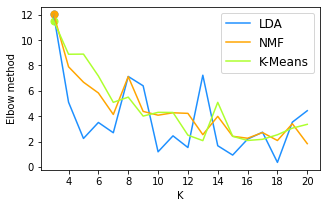

In [34]:
x=list(range(2,21))
x1=x[1:]
def y_new(y):
    y_new=[]
    for i in range(len(y)):
        if i<len(y)-1:
            rate=abs(y[i]-y[i+1])
            y_new.append(rate)
    return y_new
    
y1=y_new(data['reuter_lda'].tolist())
y2=y_new(data['reuter_nmf'].tolist())
y3=y_new(data['reuter_kmeans'].tolist())

fig = plt.figure(figsize=(5,3))
plt.plot(x1,y1,color='dodgerblue')
plt.plot(x1,y2,color='orange')
plt.plot(x1,y3,color='greenyellow')

plt.legend(labels=['LDA','NMF','K-Means'], loc='upper right',prop={'size': 12})
# plt.legend(labels=['GSDMM','SeaNMF'], loc='upper right',prop={'size': 12})

plt.xlabel('K',size=10)
plt.ylabel('Elbow method',size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xticks(list(range(2,22,2)))

plt.scatter(x=3,y=np.max(y1),s=50,color='dodgerblue')
plt.scatter(x=3,y=np.max(y2),s=50,color='orange')
plt.scatter(x=3,y=np.max(y3),s=50,color='greenyellow')
print(np.max(y1),np.max(y2))

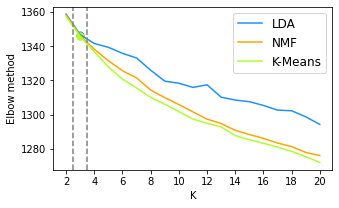

In [39]:
x=list(range(2,21))
y1=data['reuter_lda'].tolist()
y2=data['reuter_nmf'].tolist()
y3=data['reuter_kmeans'].tolist()

fig = plt.figure(figsize=(5,3))
plt.plot(x,y1,color='dodgerblue')
plt.plot(x,y2,color='orange')
plt.plot(x,y3,color='greenyellow')

plt.legend(labels=['LDA','NMF','K-Means'], loc='upper right',prop={'size': 12})
# plt.legend(labels=['GSDMM','SeaNMF'], loc='upper right',prop={'size': 12})

plt.xlabel('K',size=10)
plt.ylabel('Elbow method',size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xticks(list(range(2,22,2)))

plt.scatter(x=3,y=y1[3-2],s=50,color='dodgerblue')
plt.scatter(x=3,y=y2[3-2],s=50,color='orange')
plt.scatter(x=3,y=y3[3-2],s=50,color='greenyellow')
plt.axvline(x=2.5, color='gray', linestyle='--')  
plt.axvline(x=3.5, color='gray', linestyle='--') 

plt.savefig(r'.\output\reuter_see.png',dpi=1000,bbox_inches = 'tight') 

# A quantitative discriminant method of elbow point (AQDEB)

In [19]:
from sklearn.preprocessing import MinMaxScaler

#Classify data installation labels
def classify_cluster(topic,matrix):
    global data_initial
    data_temp=data_initial[['tag',topic]]
    topics=list(set(data_temp[topic].values.tolist()))
    matrix_3=[]
    for topic_ in topics:
        tags=data_temp[data_temp[topic]==topic_]['tag'].values.tolist()
        tags = np.array(tags).astype(int).tolist()
        matrix_3.append(matrix[tags,])
    return matrix_3
#algorithm
def calculate_ni(kmin,kmax):
    global data_initial
    md_lis=[]
    for num_topic in range(kmin,kmax):
        matrix_3=classify_cluster(f'topic{num_topic}',tv_fit.toarray())
        #1
        sse=0
        for k in range(num_topic):
            vec_u_t=np.mean(matrix_3[k],axis=0)
            for vec in matrix_3[k]:
                sse=sse+np.sqrt(np.sum((vec-vec_u_t)**2))
        md_lis.append(sse/data_initial.shape[0])

        #2
        # sse=0
        # for k in range(num_topic):
        #     vec_u_t=np.mean(matrix_3[k],axis=0)
        #     sse_=0
        #     for vec in matrix_3[k]:
        #         sse_=sse_+np.sqrt(np.sum((vec-vec_u_t)**2))
        #     sse_=sse_/len(matrix_3[k])
        #     sse=sse_+sse
        # md_lis.append(sse/num_topic)
        
    md_min=np.min(md_lis)
    md_max=np.max(md_lis)
    ni=[ (md-md_min)/(md_max-md_min)*10 for md in md_lis]
    return ni

def select_k(nmd,kmin,kmax):
    PL = list(zip(nmd, range(kmin, kmax + 1)))
    # print(PL)
    angles = []
    for i in range(len(PL) - 2):
        # print('-'*50)
        pi, ki = PL[i]
        pj, kj = PL[i + 1]
        pk, kk = PL[i + 2]
        
        a = np.array([ki, pi])
        b = np.array([kj, pj])
        c = np.array([kk, pk])
        
        distance_ij = np.sqrt(np.sum((a-b)**2))
        distance_jk = np.sqrt(np.sum((b-c)**2))
        distance_ik = np.sqrt(np.sum((a-c)**2))
        
        # print(distance_ij,'  ',distance_jk,'  ',distance_ik)
        a=(distance_ij**2 + distance_jk**2 - distance_ik**2) / (2 * distance_ij * distance_jk)
        # a=max(min(a, 1), -1)

        if a<-1 or a>1:
           a=(2 * distance_ij * distance_jk)/(distance_ij**2 + distance_jk**2 - distance_ik**2) 

        angle_rad = np.arccos(a)
        angles.append(angle_rad)
        print(i+3,a,angle_rad)
        # print(i+2,'  ', a,'   ',distance_ij**2 + distance_jk**2 - distance_ik**2,'  ',distance_ij * distance_jk)
        # print(i+2,a,angle_rad)
    Kopt = PL[angles.index(min(angles))][1]
    print(Kopt)
    return angles,Kopt,
    
kmin,kmax=2,21
nmd=calculate_ni(kmin,kmax)
angles,Kopt=select_k(nmd,kmin,kmax)
print(angles)



3 -0.9917907053911791 3.013369790192579
4 -0.9999998291859401 3.141008163958132
5 -0.9942367884035439 3.0341798434793277
6 -0.9870867319369175 2.9807128459863796
7 -0.9993900329487703 3.106663322898084
8 -0.9910609391809434 3.007783756589227
9 -0.9996087561266481 3.1136187590459397
10 -0.9999994835980215 3.140576383917947
11 -0.9836745965259464 2.9606505762641113
12 -0.9988819629247175 3.094301101026953
13 -0.9552861842560239 2.8414224755946638
14 -0.9657314312394232 2.8790432306620706
15 -0.999339602091638 3.105247898569799
16 -0.9999482058720397 3.1314147780676853
17 -0.9992317149635477 3.1023910354192314
18 -0.998469451933368 3.0862584208648913
19 -0.9995226423661024 3.1106929572444284
12
[3.013369790192579, 3.141008163958132, 3.0341798434793277, 2.9807128459863796, 3.106663322898084, 3.007783756589227, 3.1136187590459397, 3.140576383917947, 2.9606505762641113, 3.094301101026953, 2.8414224755946638, 2.8790432306620706, 3.105247898569799, 3.1314147780676853, 3.1023910354192314, 3.086

In [163]:
# all_elbow_point={}
# all_elbow_point['snippets1_seanmf']=angles

In [20]:
out_path=r'.\output\all_elbow_point.xlsx'
res=pd.read_excel(out_path)
res.insert(10,'reuter_kmeans',angles)
res.to_excel(out_path,index=False)

In [164]:
# out_path=r'.\output\all_elbow_point.xlsx'
# res=pd.DataFrame(all_elbow_point)
# res.to_excel(out_path,index=False)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
out_path=r'.\output\all_elbow_point.xlsx'
data=pd.read_excel(out_path)
columns=data.columns.tolist()
columns



['bbcsport_lda',
 'bbcsport_nmf',
 'bbcsport_kmeans',
 'bbcnews_nmf',
 'bbcnews_lda',
 'bbcnews_kmeans',
 'agnews_seanmf',
 'agnews_gsdmm',
 'snippets1_gsdmm',
 'snippets2_gsdmm',
 'reuter_kmeans',
 'reuter_nmf',
 'reuter_lda',
 'snippets2_seanmf',
 'snippets1_seanmf']

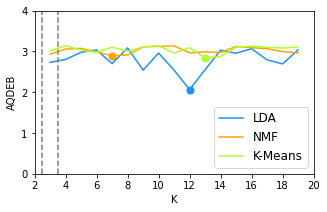

In [43]:
x1=list(range(3,20))
y1=data['reuter_lda'].tolist()
y2=data['reuter_nmf'].tolist()
y3=data['reuter_kmeans'].tolist()

fig = plt.figure(figsize=(5,3))
plt.plot(x1,y1,color='dodgerblue')
plt.plot(x1,y2,color='orange')
plt.plot(x1,y3,color='greenyellow')

plt.legend(labels=['LDA','NMF','K-Means'], loc='lower right',prop={'size': 12})
# plt.legend(labels=['GSDMM','SeaNMF'], loc='lower right',prop={'size': 12})



plt.scatter(x=12,y=np.min(y1),s=50,color='dodgerblue')
plt.scatter(x=7,y=np.min(y2),s=50,color='orange')
plt.scatter(x=13,y=np.min(y3),s=50,color='greenyellow')
plt.axvline(x=2.5, color='gray', linestyle='--')  # x=0.3 表示线条位于 x 轴 0.3 的位置
plt.axvline(x=3.5, color='gray', linestyle='--')  # x=0.3 表示线条位于 x 轴 0.3 的位置

plt.xlabel('K',size=10)
plt.ylabel('AQDEB',size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.yticks([0,1,2,3,4])
plt.xticks(list(range(2,22,2)))

plt.savefig(r'.\output\reuter_elbow_point.png',dpi=1000,bbox_inches = 'tight') 


In [190]:
y3

[3.068596247502967,
 3.091812970675542,
 2.995820618230726,
 3.121385599712256,
 2.948416095286206,
 3.126926394646078,
 3.065508400596269,
 2.889102041335455,
 3.023163026326259,
 2.956750180099569,
 3.004159206690386,
 3.025424889824038,
 3.031001029044831,
 3.067710045382658,
 3.119236351336036,
 2.965999519882133,
 2.856350690325445]

In [175]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 生成一些示例数据
# x=list(range(2,19))
# y1=data['bbcnews_lda'].tolist()
# y2=data['bbcnews_nmf'].tolist()
# y3=data['bbcnews_kmeans'].tolist()


# # 设置图形的大小（宽度，高度）
# fig, axs = plt.subplots(3, 1, figsize=(5, 4))  # 3行1列，宽度8英寸，高度12英寸
# # 绘制第一个子图
# axs[0].plot(x, y1, 'dodgerblue',label='LDA')
# # axs[0].set_title('Sine Wave')
# axs[0].legend(loc='lower right',prop={'size': 12})
# axs[0].set_xticks(list(range(2,20,2)))  
# axs[0].set_yticks([0,2,4])  
# # 绘制第二个子图
# axs[1].plot(x, y2,color='orange',label='NMF')
# # axs[1].set_title('Cosine Wave')
# axs[1].legend(loc='lower right',prop={'size': 12})
# axs[1].set_xticks(list(range(2,20,2)))  
# axs[1].set_yticks([0,2,4])  

# # 绘制第三个子图
# axs[2].plot(x, y3,color='greenyellow',label='K-Means')
# # axs[2].set_title('Tangent Wave')
# axs[2].legend(loc='lower right',prop={'size': 12})
# axs[2].set_xticks(list(range(2,20,2)))  
# axs[2].set_yticks([0,2,4])  

# plt.tight_layout()

# # plt.show()
# plt.savefig(r'.\output\bbcnews_elbow_point.png',dpi=1000,bbox_inches = 'tight') 
# # plt.savefig(r'.\output\bbcsport_elbow_point1.png', dpi=300) 

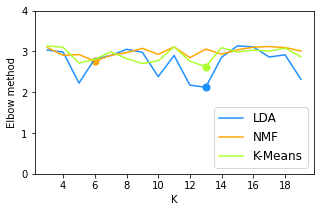